In [43]:
import torch
from torch.utils.data import DataLoader
import monai
from monai.transforms import (
    Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, Resized, EnsureTyped, Lambdad, AsDiscrete
)
from monai.data import (decollate_batch, Dataset)
from monai.networks.nets import UNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
import matplotlib.pyplot as plt
import sys
import logging
from monai.utils import set_determinism
import os
from glob import glob

# Set logging and configuration
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Set determinism for reproducibility
set_determinism(seed=0)

# Define paths to images and masks
#data_dir = "Rabbit AI - Thorax & Abdomen/ground_truth"
data_dir = "Rabbit AI - New/ground_truth"
image_files = sorted(glob(os.path.join(data_dir, "images", "*.tif")))
mask_files = sorted(glob(os.path.join(data_dir, "masks", "*.tif")))

# Ensure that the number of images and masks are the same
assert len(image_files) == len(mask_files), "Number of images and masks must be the same"

# Create the train and validation file lists
train_files = [{"img": img, "seg": seg} for img, seg in zip(image_files[:25], mask_files[:25])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(image_files[25:], mask_files[25:])]

# Print out some paths to verify
print(train_files[:2])
print(val_files[:2])

# Data loading and transformations
data_transform = Compose([
    LoadImaged(keys=["img", "seg"], reader="PILReader"),  # Use PILReader explicitly for TIFF files
    EnsureChannelFirstd(keys=["img", "seg"]),
    ScaleIntensityd(keys=["img"]),
    Lambdad(keys="seg", func=lambda x: torch.where(x > 0, 1, 0)),  # Binarize the mask
    Resized(keys=["img", "seg"], spatial_size=(256, 256)),
    EnsureTyped(keys=["img", "seg"]),
])

train_ds = Dataset(data=train_files, transform=data_transform)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)

val_ds = Dataset(data=val_files, transform=data_transform)
val_loader = DataLoader(val_ds, batch_size=4, shuffle=False)

MONAI version: 1.3.1
Numpy version: 1.21.6
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 96bfda00c6bd290297f5e3514ea227c6be4d08b4
MONAI __file__: /Users/<username>/opt/anaconda3/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: NOT INSTALLED or UNKNOWN VERSION.
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: 1.11.4
Pillow version: 9.0.1
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.36.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or 

Epoch 1/50
Epoch 1 average loss: 0.4798
Epoch 2/50
Epoch 2 average loss: 0.4273
Saved new best metric model
Current epoch: 2 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 3/50
Epoch 3 average loss: 0.3995
Epoch 4/50
Epoch 4 average loss: 0.3806
Current epoch: 4 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 5/50
Epoch 5 average loss: 0.3576
Epoch 6/50
Epoch 6 average loss: 0.3444
Current epoch: 6 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 7/50
Epoch 7 average loss: 0.3290
Epoch 8/50
Epoch 8 average loss: 0.3126
Current epoch: 8 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 9/50
Epoch 9 average loss: 0.3014
Epoch 10/50
Epoch 10 average loss: 0.2878
Current epoch: 10 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 11/50
Epoch 11 average loss: 0.2796
Epoch 12/50
Epoch 12 average loss: 0.2805
Current epoch: 12 current mean dice: 0.6476 best mean dice: 0.6476 at epoch 2
Epoch 13/50
Epoch 13 a

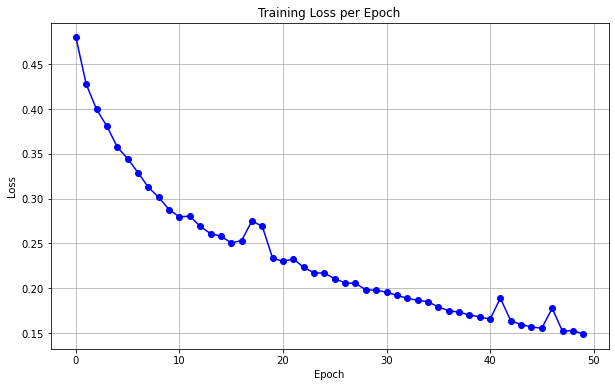

In [44]:
# Model definition
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,  # Updated argument name
    in_channels=1,
    out_channels=2,  # Ensure the model is defined to output two classes
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)  # Ensure softmax is used for multi-class segmentation
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

# Training loop
max_epochs = 50
epoch_losses = []
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

def visualize_predictions(images, true_masks, pred_masks, raw_outputs, num_images=3, alpha=0.5):
    for i in range(num_images):
        fig, ax = plt.subplots(1, 3, figsize=(20, 5))
        ax[0].imshow(images[i, 0], cmap='gray')
        ax[0].axis('off')
        ax[0].set_title('Original Image')
        ax[1].imshow(images[i, 0], cmap='gray')
        ax[1].imshow(true_masks[i, 0], alpha=alpha)
        ax[1].axis('off')
        ax[1].set_title('Ground Truth Mask')
        ax[2].imshow(images[i, 0], cmap='gray')
        ax[2].imshow(pred_masks[i, 0], alpha=alpha)
        ax[2].axis('off')
        ax[2].set_title('Predicted Mask')
        plt.tight_layout()
        plt.show()

for epoch in range(max_epochs):
    print(f"Epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)

        # Debug: Print shape and unique values of labels
        #print(f"Labels shape: {labels.shape}, unique values: {torch.unique(labels)}")

        optimizer.zero_grad()
        outputs = model(inputs)

        # Debug: Print shape of outputs
        #print(f"Outputs shape: {outputs.shape}")

        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    epoch_losses.append(epoch_loss)

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:
                val_images, val_labels = val_data["img"].to(device), val_data["seg"].to(device)
                val_outputs = model(val_images)
                val_outputs = torch.softmax(val_outputs, dim=1)  # Ensure softmax for multi-class
                dice_metric(y_pred=val_outputs, y=val_labels)
            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("Saved new best metric model")
            print(f"Current epoch: {epoch + 1} current mean dice: {metric:.4f} best mean dice: {best_metric:.4f} at epoch {best_metric_epoch}")


# Plotting the epoch losses
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

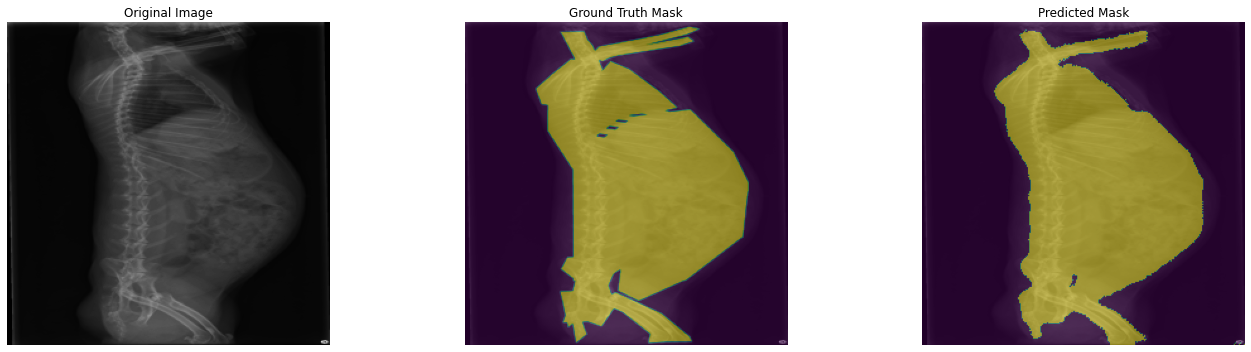

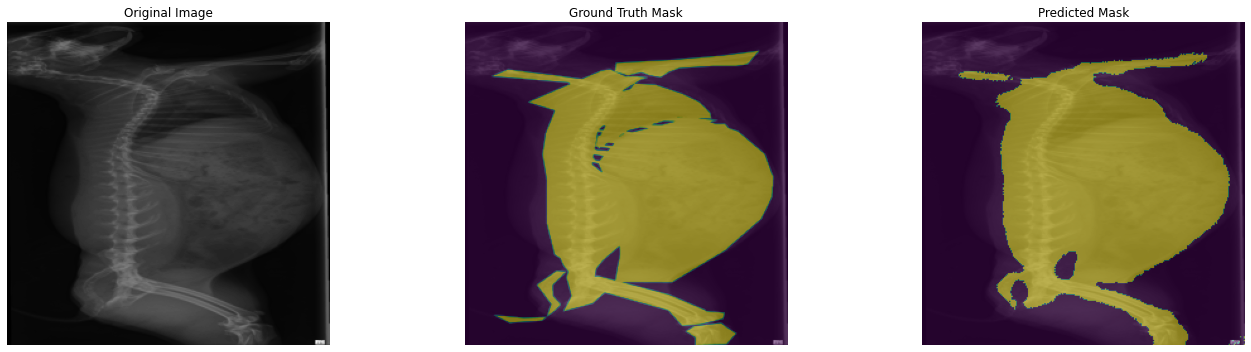

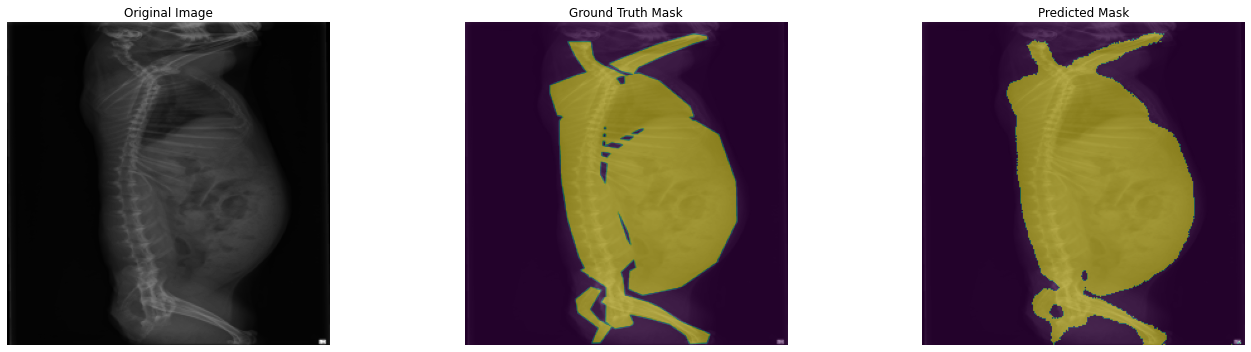

In [47]:
# Evaluate and visualize predictions
model.eval()
with torch.no_grad():
    for batch in train_loader:
        images, true_masks = batch["img"].to(device), batch["seg"].to(device)
        predictions = model(images)
        raw_outputs = torch.softmax(predictions, dim=1)
        predicted_masks = torch.argmax(raw_outputs, dim=1, keepdim=True).float()

        images_np = images.cpu().numpy()
        true_masks_np = true_masks.cpu().numpy()
        predicted_masks_np = predicted_masks.cpu().numpy()
        raw_outputs_np = raw_outputs.cpu().numpy()S

        visualize_predictions(images_np, true_masks_np, predicted_masks_np, raw_outputs_np, num_images=3)
        break

In [46]:
# Ensure your model is in evaluation mode
model.eval()

all_predictions = []
all_ground_truths = []

# Perform inference on your test data
with torch.no_grad():
    for batch in val_loader:
        inputs = batch['img'].to(device)  # Adjust to your data format
        labels = batch['seg'].to(device)  # Adjust to your data format
        
        outputs = model(inputs)
        
        # Convert outputs to binary predictions by taking the channel with the highest logit
        preds = torch.argmax(outputs, dim=1, keepdim=True).float()
        
        
        all_predictions.append(preds.cpu())
        all_ground_truths.append(labels.cpu())

# Concatenate all predictions and ground truths
all_predictions = torch.cat(all_predictions)
all_ground_truths = torch.cat(all_ground_truths)

# Print concatenated shapes for debugging
print(f"all_predictions shape: {all_predictions.shape}")
print(f"all_ground_truths shape: {all_ground_truths.shape}")

def calculate_metrics(predictions, ground_truths):
    # Ensure predictions and ground truths have the same shape
    if predictions.shape != ground_truths.shape:
        raise ValueError("Shape mismatch between predictions and ground truths")
    
    # Initialize DiceMetric
    dice_metric = DiceMetric(include_background=False, reduction="mean")
    
    # Ensure predictions are discrete (binary in this case)
    post_pred = AsDiscrete(threshold=0.5)
    
    # Apply the discrete transformation to the predictions
    predictions = [post_pred(i) for i in decollate_batch(predictions)]
    ground_truths = decollate_batch(ground_truths)
    
    # Compute Dice score
    dice_metric(y_pred=predictions, y=ground_truths)
    dice_score = dice_metric.aggregate().item()
    
    # Clear the metric state
    dice_metric.reset()
    
    # Flatten the tensors to calculate pixel accuracy
    predictions_flat = torch.cat([i.view(-1) for i in predictions])
    ground_truths_flat = torch.cat([i.view(-1) for i in ground_truths])
    
    # Calculate pixel accuracy
    pixel_accuracy = torch.mean((predictions_flat == ground_truths_flat).float()).item()
    
    # Calculate IoU
    intersection = (predictions_flat * ground_truths_flat).sum().item()
    union = predictions_flat.sum().item() + ground_truths_flat.sum().item() - intersection
    iou = intersection / union if union != 0 else 0.0
    
    return {
        "pixel_accuracy": pixel_accuracy,
        "dice_score": dice_score,
        "iou": iou
    }

# Calculate metrics
metrics = calculate_metrics(all_predictions, all_ground_truths)
print(metrics)

all_predictions shape: torch.Size([6, 1, 256, 256])
all_ground_truths shape: torch.Size([6, 1, 256, 256])
{'pixel_accuracy': 0.8999506831169128, 'dice_score': 0.8980816006660461, 'iou': 0.8255403035082348}
